# IRIS- Tensor
## Matthew Johnson, Feb 15, 2019

- MSE, ReLU: 0.83

In [1]:
import os
import torch
import torchvision
from torchvision import transforms
from my_classes import IrisDataset

# Data type for tensors
dtype = torch.float

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#dataset = IrisDataset(transform=trans)

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import my_classes as mc

##################
# IMPORTING DATA #
##################

iris_data = load_iris()
features, pre_labels = iris_data.data, iris_data.target

labels = mc.one_hot_encode(pre_labels, 3)

feature_train, feature_test, labels_train, labels_test = train_test_split(features, labels, random_state = 17)

# Load the standard scaler
sc = StandardScaler()

# Compute the mean and standard deviation based on the training data
sc.fit(feature_train)

# Scale the training data to be of mean 0 and of unit variance
feature_train = sc.transform(feature_train)

# Scale the test data to be of mean 0 and of unit variance
feature_test = sc.transform(feature_test)


In [3]:
import torch.utils.data as data_utils

batch_size = 14

# Training
train = data_utils.TensorDataset(torch.from_numpy(feature_train).float().to(device), 
                                 torch.from_numpy(labels_train).float().to(device))
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)
data_iter = iter(train_loader)
feats, labels = next(data_iter)

# Testing
test = data_utils.TensorDataset(torch.from_numpy(feature_test).float().to(device), 
                                 torch.from_numpy(labels_test).float().to(device))
test_loader = data_utils.DataLoader(test, batch_size=batch_size, shuffle=True)
test_iter = iter(test_loader)

print(feats.shape)
print(labels.shape)

torch.Size([14, 4])
torch.Size([14, 3])


In [4]:
import numpy as np

# One hot encoding function
def one_hot_encode(pre_labels, n_classes):
    labels = []

    for num in range(len(pre_labels)):
        # idx <- class: 0, 1, 2
        idx = pre_labels[num]
        # Array of Zeros
        arr = np.zeros(n_classes)
        # One hot encode array by class index
        arr[idx] = 1
        # Add array to labels (list)
        labels.append(arr)

    labels = np.array(labels, dtype=int)

    return labels

# SOFTMAX
def softmax(X):
    '''
    X: output of last fc layer, dim = [num_examples, num_classes]
    output: 
    '''
    exps = torch.exp(X - torch.max(X))
    return exps / exps.sum()

## Training

In [12]:

'''
N: batch size; 
D_in: input dimension;
H_1, H_2: hidden dimensions; 
D_out: output dimension.
'''

N = batch_size # 64
D_in = 4
H_1 = 7
#H_2 = 3
D_out = 3

# Hyperparamters
learning_rate = 0.001
num_steps = 5000

# Tracking losses
loss_list = []
weights = {}

def train():
    # Randomly initialize weights
    w1 = torch.randn(D_in, H_1, device=device, dtype=dtype)
    w2 = torch.randn(H_1, D_out, device=device, dtype=dtype)

    # Data Iter (fresh)
    data_iter = iter(train_loader)
    iter_per_epoch = len(train_loader) # 

    for t in range(num_steps):

        # Reset the data_iter
        if (t + 1) % iter_per_epoch == 0:
            data_iter = iter(train_loader)

        # Grab feats and labels
        x, y = next(data_iter)

        # Forward pass: compute predicted y
        h1 = x.mm(w1)
        h1_relu = h1.clamp(min=0)
        h2 = h1_relu.mm(w2)
        
        #y_pred = torch.stack([softmax(_) for _ in h2])
        y_pred = h2

        # Compute and print loss
        loss = (y_pred - y).pow(2).sum().item()
        
        # Backprop to compute gradients of w1, w2, and w3 with respect to loss
        grad_y_pred = 2.0 * (y_pred - y)

        grad_w2 = h1_relu.t().mm(grad_y_pred)
        
        grad_h_relu = grad_y_pred.mm(w2.t())
        grad_h = grad_h_relu.clone()
        grad_h[h1 < 0] = 0
        
        grad_w1 = x.t().mm(grad_h)
        
        # Update weights using gradient descent
        w1 -= learning_rate * grad_w1
        w2 -= learning_rate * grad_w2

        if t < 10 or (t + 1) % 1000 == 0:
            print(f'Step [{t+1}/{num_steps}], Loss: {loss:.4}')
            
        loss_list.append(loss)
        
    weights['w1'] = w1
    weights['w2'] = w2

## Prediction

In [6]:
def test():
    
    w1 = weights['w1']
    w2 = weights['w2']
    
    correct = 0
    loss = 0
    total = 0

    test_iter = iter(test_loader)

    feats, labels = next(test_iter)

    for images, labels in test_iter:

        # Grab images and labels
        #x, y = next(data_iter)
        x = images
        y = labels

        # Forward pass: compute predicted y
        h1 = x.mm(w1)
        h1_relu = h1.clamp(min=0)

        h2 = h1_relu.mm(w2)

        y_pred = torch.stack([softmax(_) for _ in h2])

        correct += (torch.max(labels, 1)[1] == torch.max(y_pred, 1)[1]).sum().item()
        loss += (y_pred - y).pow(2).sum().item()
        total += len(labels)

    print(f'Acc: {correct/total:.2} Loss: {loss/total:.4}')

In [13]:
train()

Step [1/5000], Loss: 347.2
Step [2/5000], Loss: 153.7
Step [3/5000], Loss: 144.9
Step [4/5000], Loss: 75.32
Step [5/5000], Loss: 127.2
Step [6/5000], Loss: 138.9
Step [7/5000], Loss: 59.68
Step [8/5000], Loss: 42.76
Step [9/5000], Loss: 56.29
Step [10/5000], Loss: 58.98
Step [1000/5000], Loss: 3.1
Step [2000/5000], Loss: 1.377
Step [3000/5000], Loss: 4.157
Step [4000/5000], Loss: 2.917
Step [5000/5000], Loss: 3.607


In [14]:
test()

Acc: 0.83 Loss: 0.419


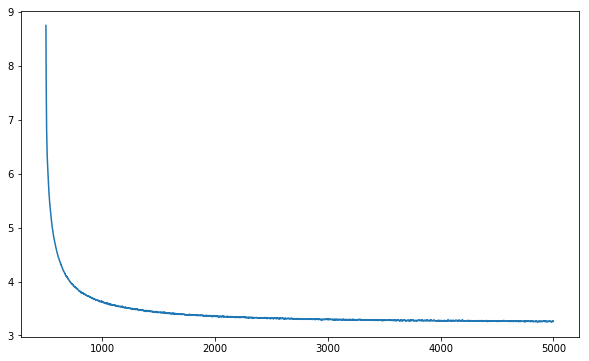

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

mavg_loss = pd.DataFrame({'loss': loss_list}).rolling(500).mean()

plt.figure(figsize=(10, 6))
plt.plot(mavg_loss);